# Potato Disease Classification

* Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

In [1]:
import tensorflow as tf
from tensorflow.keras import models , layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE= 256
BATCH_SIZE=32

# Import data into tensorflow dataset object

In [3]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    
    "potato-disease",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE

)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = data.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(data)

68

In [6]:
for image_batch , label_batch in data.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 0 1 0 1 0 0 1 2 0 0 0 0 1 1 1 1 1 0 0 1 1 0 0 2 0 1 0 1 0 0]


# Visualize some of the images from our dataset

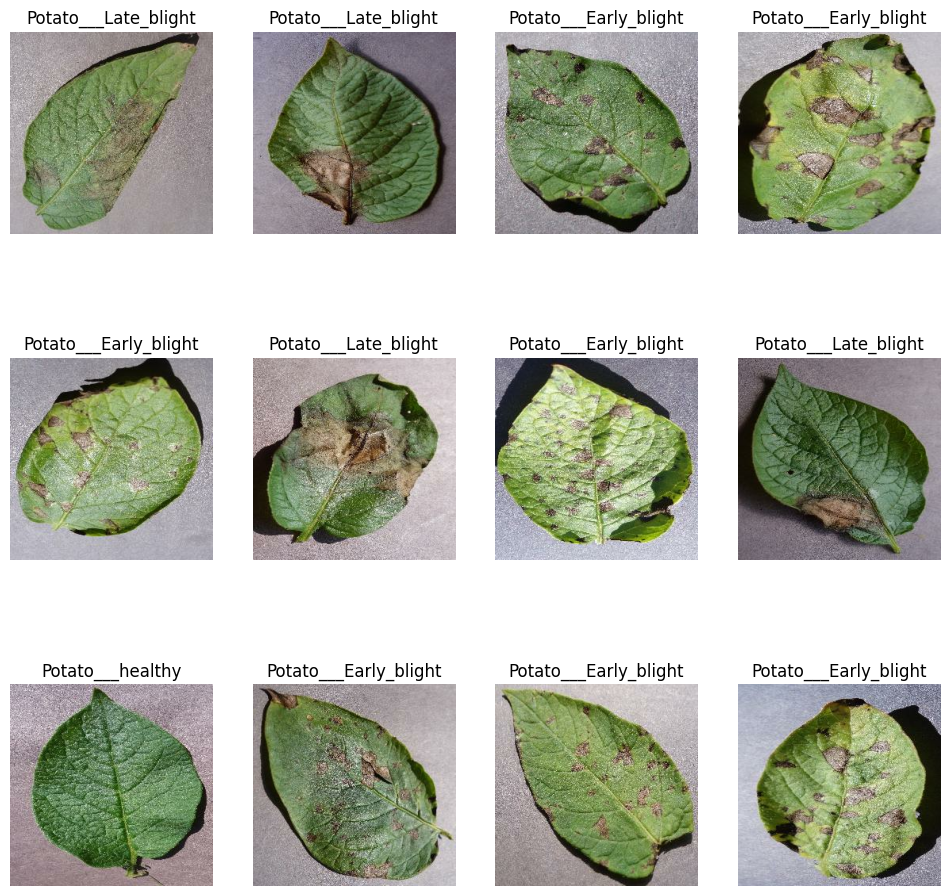

In [7]:
plt.figure(figsize=(12,12))
for image_batch , label_batch in data.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

# Function to Split Dataset

* 80% ==> training
* 20% ==> validation , 10% test

In [8]:
print(len(data))

68


In [9]:
train_size = 0.8
len(data) * train_size

54.400000000000006

In [10]:
train_ds = data.take(54)
print(len(train_ds))

54


In [11]:
test_ds = data.skip(54)
len(test_ds)

14

In [12]:
val_size = 0.1
len(data)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(df , train_split = 0.8 , val_split = 0.1 , test_split = 0.1 , shuffle = True , shuffle_size = 10000):
    
    df_size = len(df)
    
    if shuffle:
        df = df.shuffle(shuffle_size , seed =12)
        
    train_size = int(train_split * df_size)
    val_size = int(val_split * df_size)
    
    train_df = df.take(train_size)
    
    val_df = df.skip(train_size).take(val_size)
    test_df = df.skip(train_size).skip(val_size)
    
    return train_df , val_df , test_df

In [16]:
train_df , val_df , test_df = get_dataset_partitions_tf(data)

In [17]:
print(len(train_df))

54


In [18]:
print(len(val_df))

6


In [19]:
print(len(test_df))

8


In [20]:
train_df = train_df.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_df = val_df.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_df = test_df.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

# Building the Model

In [21]:
resize_and_rescale = tf.keras.Sequential([
    
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [22]:
data_augmentation = tf.keras.Sequential([
    
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [23]:
CHANNELS = 3
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [24]:
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_df,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_df,
    verbose=1,
    )

Epoch 1/50
54/54 [==============================] - 207s 3s/step - loss: 0.9118 - accuracy: 0.4705 - val_loss: 0.8779 - val_accuracy: 0.4740
Epoch 2/50
54/54 [==============================] - 159s 3s/step - loss: 0.7021 - accuracy: 0.6574 - val_loss: 0.4975 - val_accuracy: 0.8125
Epoch 3/50
54/54 [==============================] - 150s 3s/step - loss: 0.5000 - accuracy: 0.7795 - val_loss: 0.3466 - val_accuracy: 0.8594
Epoch 4/50
54/54 [==============================] - 166s 3s/step - loss: 0.3669 - accuracy: 0.8443 - val_loss: 0.4995 - val_accuracy: 0.7188
Epoch 5/50
54/54 [==============================] - 157s 3s/step - loss: 0.3014 - accuracy: 0.8762 - val_loss: 0.2483 - val_accuracy: 0.9010
Epoch 6/50
54/54 [==============================] - 166s 3s/step - loss: 0.2393 - accuracy: 0.9068 - val_loss: 0.1732 - val_accuracy: 0.9323
Epoch 7/50
54/54 [==============================] - 159s 3s/step - loss: 0.1637 - accuracy: 0.9381 - val_loss: 0.1627 - val_accuracy: 0.9375
Epoch 8/50
54

In [27]:
scores = model.evaluate(test_df)

8/8 [==============================] - 7s 551ms/step - loss: 0.0137 - accuracy: 0.9883


In [29]:
scores

[0.013667589984834194, 0.98828125]

# Plotting the Accuracy and Loss Curves

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
type(history.history['loss'])

list

In [34]:
len(history.history['loss'])

50

In [35]:
history.history['loss'][:5] # show loss for first 5 epochs


[0.9117909669876099,
 0.7021335959434509,
 0.4999656081199646,
 0.3669113218784332,
 0.30140724778175354]

In [36]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [37]:
EPOCHS = 50

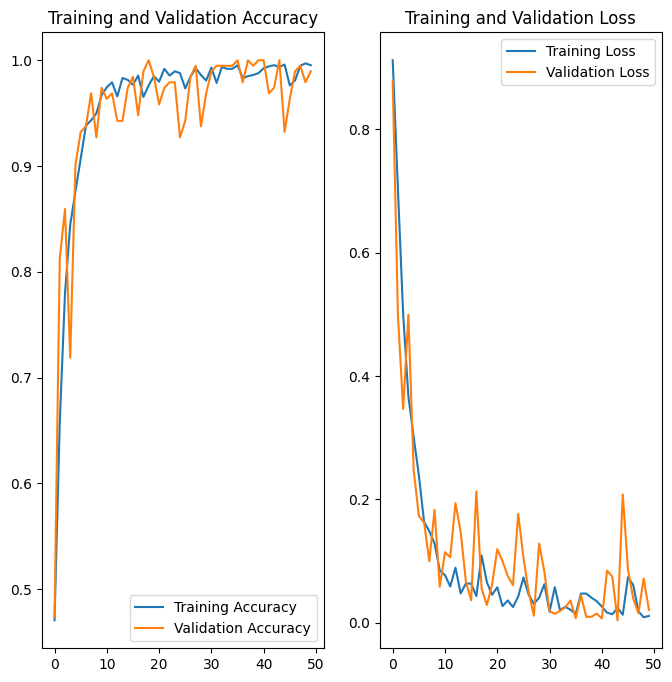

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
predicted label: Potato___Late_blight


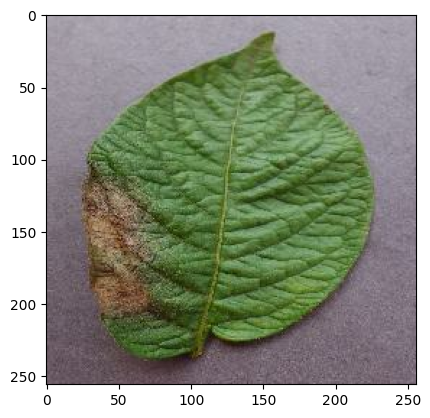

In [39]:

import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

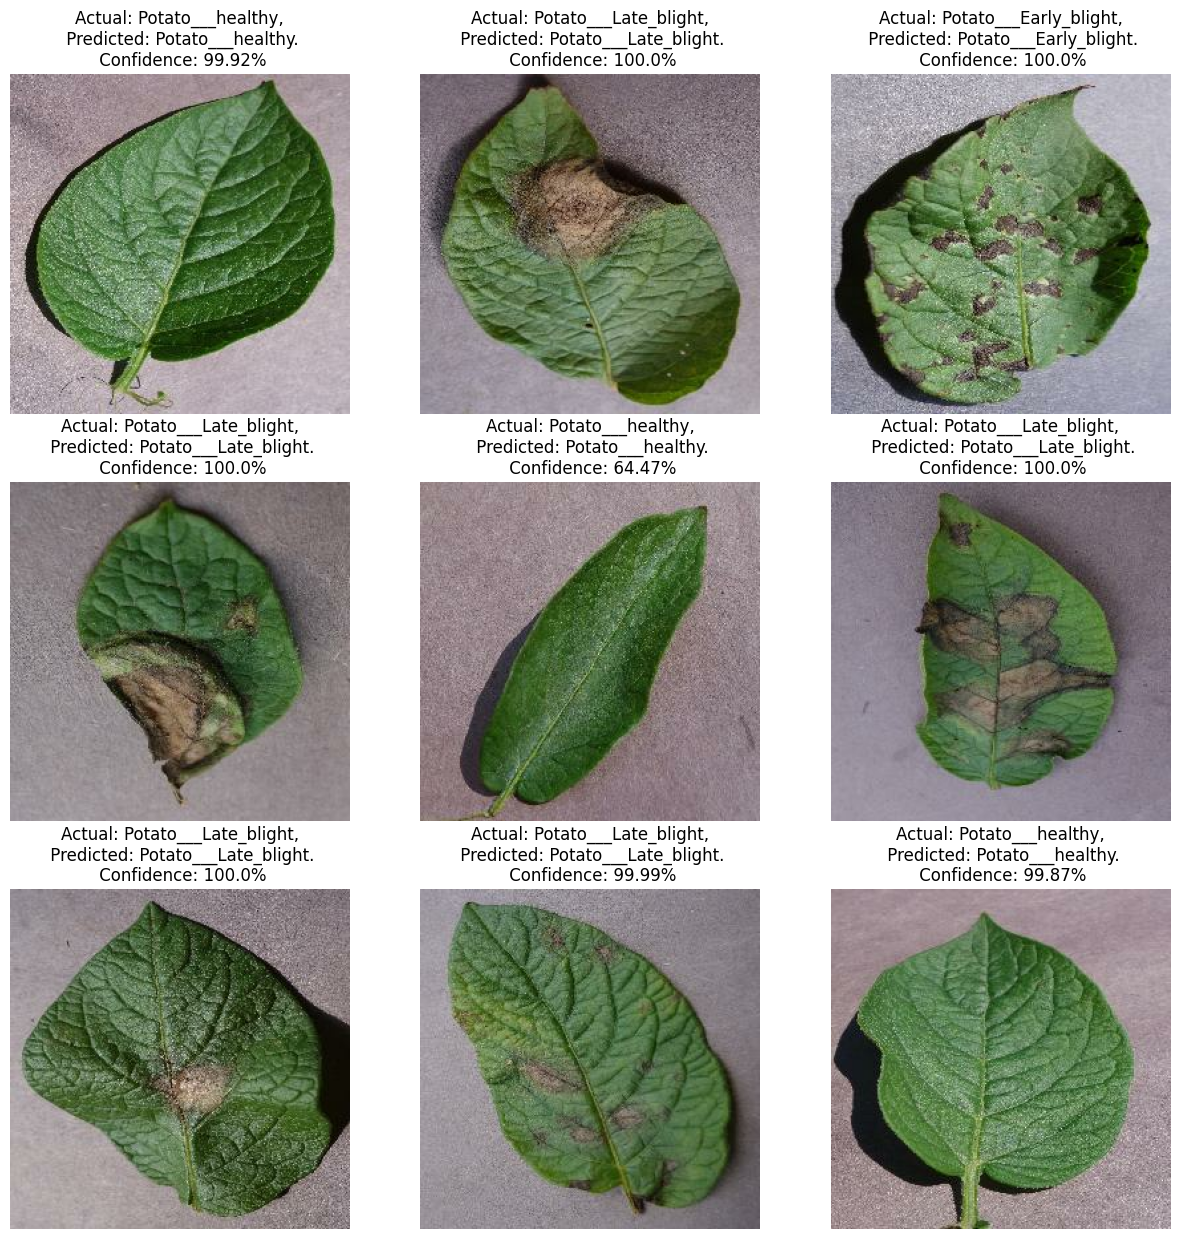

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving the Model

In [42]:
import os
model_version=max([int(i) for i in os.listdir("./models") + [0]])+1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/2\assets
